# 0. Attaching libraries

In [1]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [2]:
# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [3]:
from dateutil.relativedelta import relativedelta
import builtins

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

import matplotlib.patches as mpatches

# 1. Reading the core Dataset from the golden source

In [4]:
#csv_file  = "https://raw.githubusercontent.com/mithridata-com/NOVAIMS_BDMwDS_PROJECT/refs/heads/main/00%20Data/Dataset.csv?token=GHSAT0AAAAAADEUY5L7CYN33VQB6LEZUFGK2CIWL5A"
csv_file = r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\00 Data\Dataset.csv"

excel_path  = (r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\02 Output\02 TB Conversion Analytics.xlsx")

In [5]:
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [6]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


In [7]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

## NEW COLUMNS

In [8]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [9]:
df['premium_total'] = df['premium_wa'].fillna(0) + df['premium_other'].fillna(0)

In [10]:
df['premium_discount'] = df['premium_other'].fillna(0) - df['premium_other_incl_discount'].fillna(0)

In [11]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default="")

In [12]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [13]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [14]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [15]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [16]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [17]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [18]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [19]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [20]:
# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
df['car_age_norm'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")


In [21]:
df

affinity_name           status_report  offer_number  policy_number  \
0           Insuro        Requestwithdrawn          1000        10000.0   
1            other  Tailoredofferwithdrawn          1001            NaN   
2            other       Incompleterequest          1002            NaN   
3            other           Policycreated          1003        10002.0   
4            other           Policycreated          1004        10003.0   
...            ...                     ...           ...            ...   
9368         other         Requestaccepted          9439        11946.0   
9369         other         Waitforapproval          9440        11947.0   
9370        Insuro  Tailoredofferrequested          9441            NaN   
9371           T&B     Calculatenewpremium          9442            NaN   
9372           T&B       Incompleterequest          9443            NaN   

      zipcode_link  zip4 birth_date       brand  date_offer date_request  ...  \
0            10000  2132 1985-01-01     HYUNDAI  2018-10-11   2018-10-11  ...   
1            10001  6027 1987-04-01        AUDI  2018-10-11          NaN  ...   
2            10002  3824 1972-11-01  VOLKSWAGEN  2018-10-11          NaN  ...   
3            10003  6921 1983-08-01       MAZDA  2018-10-11   2018-10-11  ...   
4            10004  8266 1990-04-01       VOLVO  2018-10-12   2018-10-12  ...   
...            ...   ...        ...         ...         ...          ...  ...   
9368         15568  1161 1960-09-01  VOLKSWAGEN  2020-03-08   2020-03-08  ...   
9369         15582  5015 1953-04-01      NISSAN  2020-03-08   2020-03-08  ...   
9370         10332  3078 1976-04-01      TOYOTA  2020-03-08          NaN  ...   
9371         12968  1965 1951-07-01      TOYOTA  2020-03-08          NaN  ...   
9372         15526  1165 1964-01-01       VOLVO  2020-03-08          NaN  ...   

     premium_total  premium_discount                 coverage_type   age  \
0              0.0               0.0   1. Only liability insurance  34.0   
1              0.0               0.0                                32.0   
2              0.0               0.0     3. Liability + full casco  47.0   
3              0.0               0.0  2. Liability + limited casco  36.0   
4              0.0               0.0   1. Only liability insurance  29.0   
...            ...               ...                           ...   ...   
9368           0.0               0.0     3. Liability + full casco  59.0   
9369           0.0               0.0     3. Liability + full casco  66.0   
9370           0.0               0.0  2. Liability + limited casco  43.0   
9371           0.0               0.0  2. Liability + limited casco  68.0   
9372           0.0               0.0     3. Liability + full casco  55.0   

     age_band       urb_norm buildmonth_num build_date car_age car_age_norm  
0       25–34  3-Mid-to-High             06 2016-06-01     3.0          0-3  
1       25–34      7-VeryLow             06 2015-06-01     4.0          4-7  
2       45–54         2-High             04 2016-04-01     3.0          0-3  
3       35–44          4-Mid             06 2009-06-01    10.0         8-11  
4       25–34          4-Mid             01 2003-01-01    16.0          12+  
...       ...            ...            ...        ...     ...          ...  
9368    55–64          6-Low             12 2011-12-01     7.0          4-7  
9369      65+         2-High             02 2017-02-01     2.0          0-3  
9370    35–44     1-VeryHigh             01 2004-01-01    15.0          12+  
9371      65+          4-Mid             09 2004-09-01    15.0          12+  
9372    55–64      7-VeryLow             06 2015-06-01     4.0          4-7  

[9373 rows x 89 columns]

In [22]:
# list of cols to convert
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']

# coerce to numeric, invalid parsing becomes NaN
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# IMPUTATION

In [23]:
num_cols = [
    'worth_car',
    'weight_car',
    'mileage_car',
    'power_car'
]

cat_cols = [
    'chassis',
    'fuel_car',
    'drive',
    'turbo',
    'transmission'
]


In [24]:
# for each numeric column, fill NAs with the mean _within_ its brand
df[num_cols] = (
    df
    .groupby('brand')[num_cols]
    .transform(lambda col:
        col.fillna(col.mean())    # group-mean imputation
    )
)

In [25]:
def fill_with_mode(series):
    # find the most common value
    modes = series.dropna().mode()
    if len(modes) > 0:
        return series.fillna(modes.iloc[0])
    else:
        return series

df[cat_cols] = (
    df
    .groupby('brand')[cat_cols]
    .transform(fill_with_mode)
)

In [26]:
print(df[num_cols + cat_cols].isna().sum())

worth_car       302
weight_car      302
mileage_car     302
power_car       302
chassis         302
fuel_car        302
drive           302
turbo           302
transmission    302
dtype: int64


In [27]:
mode_income = (
    df
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df = df.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df['INCOME_filled'] = df['INCOME'].fillna(df['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df.drop(columns=['mode_income'], inplace=True)

In [28]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df = df.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df['INCOME_final'] = df['INCOME_filled'].fillna(df['mode_income_prov'])

# Drop helper columns if desired
df.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

## CLUSTERING BY REGION PROFILE

In [29]:
columns_to_keep = [#"PROVINCE",
                   'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
                   'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
                   'OWN_HOUSE', 'AVG_HOUSE',
                   #'STAGE_OF_LIFE',
                   'SINGLE', 'FAM', 'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD', 'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED','FAM_WCHILD_OLD',
                   'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR', # from regional
                   'conv'
                   #'age', 'coverage_type','car_age', # from new columns                  
       ]

In [30]:
#df_sub = df[(df["affinity_name"]=="T&B")&(df["conv"]==1)][columns_to_keep].copy()
df_tb = df[(df["affinity_name"]=="T&B")][columns_to_keep].copy()

In [31]:
df_tb.shape

(3694, 30)

In [32]:
print(df_tb.isna().sum())

URB                0
INCOME_final       0
SOCCL_A           15
SOCCL_B1          15
SOCCL_B2          15
SOCCL_C           15
SOCCL_D           15
EDU_HIGH          15
EDU_MID           15
EDU_LOW           15
DINK              15
OWN_HOUSE         16
AVG_HOUSE         40
SINGLE            15
FAM               15
FAM_WCHILD        15
SINGLES_YOUNG     15
SINGLES_MID       15
SINGLES_OLD       15
FAM_CHILD_Y       15
FAM_CHILD_O       15
FAM_WCHILD_Y      15
FAM_WCHILD_MED    15
FAM_WCHILD_OLD    15
CIT_HOUSEHOLD     15
LOAN              15
SAVINGS           15
SHOP_ONLINE       15
CAR               15
conv               0
dtype: int64


In [33]:
df_tb.dropna(axis=0, how='any', inplace=True)

In [34]:
print(df_tb.isna().sum())

URB               0
INCOME_final      0
SOCCL_A           0
SOCCL_B1          0
SOCCL_B2          0
SOCCL_C           0
SOCCL_D           0
EDU_HIGH          0
EDU_MID           0
EDU_LOW           0
DINK              0
OWN_HOUSE         0
AVG_HOUSE         0
SINGLE            0
FAM               0
FAM_WCHILD        0
SINGLES_YOUNG     0
SINGLES_MID       0
SINGLES_OLD       0
FAM_CHILD_Y       0
FAM_CHILD_O       0
FAM_WCHILD_Y      0
FAM_WCHILD_MED    0
FAM_WCHILD_OLD    0
CIT_HOUSEHOLD     0
LOAN              0
SAVINGS           0
SHOP_ONLINE       0
CAR               0
conv              0
dtype: int64


In [35]:
df_tb[columns_to_keep[1:]].corr()

INCOME_final   SOCCL_A  SOCCL_B1  SOCCL_B2   SOCCL_C  \
INCOME_final        1.000000 -0.421167 -0.211338  0.125147  0.326162   
SOCCL_A            -0.421167  1.000000  0.076337 -0.564669 -0.535601   
SOCCL_B1           -0.211338  0.076337  1.000000 -0.091165 -0.511949   
SOCCL_B2            0.125147 -0.564669 -0.091165  1.000000  0.150354   
SOCCL_C             0.326162 -0.535601 -0.511949  0.150354  1.000000   
SOCCL_D             0.421325 -0.486430 -0.501999 -0.041809  0.425852   
EDU_HIGH           -0.419384  0.910176  0.102304 -0.507901 -0.516838   
EDU_MID            -0.090023 -0.208244  0.648350  0.187500 -0.166048   
EDU_LOW             0.453942 -0.689096 -0.496034  0.371408  0.590347   
DINK               -0.361932  0.512512  0.502509 -0.201451 -0.563319   
OWN_HOUSE          -0.363583  0.564287  0.534302 -0.273021 -0.594775   
AVG_HOUSE          -0.319629  0.698455  0.303423 -0.344152 -0.552543   
SINGLE              0.282035 -0.517877 -0.370742  0.254990  0.501583   
FAM                -0.153203  0.200712  0.158526  0.012648 -0.200539   
FAM_WCHILD         -0.215017  0.383970  0.447592 -0.151359 -0.467924   
SINGLES_YOUNG       0.115581 -0.173134 -0.250855  0.065150  0.342855   
SINGLES_MID         0.107050 -0.292503 -0.179766  0.215561  0.325934   
SINGLES_OLD         0.284683 -0.437714 -0.258644  0.184276  0.325935   
FAM_CHILD_Y        -0.026204 -0.002113  0.070358  0.074891 -0.009179   
FAM_CHILD_O        -0.141421  0.250218  0.184729 -0.049538 -0.273144   
FAM_WCHILD_Y       -0.049722 -0.008296  0.105755  0.099989 -0.045871   
FAM_WCHILD_MED     -0.115800  0.208098  0.252382 -0.096234 -0.233295   
FAM_WCHILD_OLD     -0.160233  0.297407  0.382196 -0.132814 -0.397478   
CIT_HOUSEHOLD      -0.177223  0.283781  0.235280 -0.055434 -0.327550   
LOAN               -0.066365 -0.222912 -0.028095  0.288997  0.147017   
SAVINGS            -0.397322  0.564561  0.453426 -0.230174 -0.522651   
SHOP_ONLINE        -0.440664  0.547274  0.503909 -0.144074 -0.581647   
CAR                -0.298200  0.418713  0.482640 -0.136840 -0.545952   
conv                0.018475 -0.035699 -0.058988  0.024636  0.050904   

                 SOCCL_D  EDU_HIGH   EDU_MID   EDU_LOW      DINK  ...  \
INCOME_final    0.421325 -0.419384 -0.090023  0.453942 -0.361932  ...   
SOCCL_A        -0.486430  0.910176 -0.208244 -0.689096  0.512512  ...   
SOCCL_B1       -0.501999  0.102304  0.648350 -0.496034  0.502509  ...   
SOCCL_B2       -0.041809 -0.507901  0.187500  0.371408 -0.201451  ...   
SOCCL_C         0.425852 -0.516838 -0.166048  0.590347 -0.563319  ...   
SOCCL_D         1.000000 -0.490887 -0.350879  0.688399 -0.550091  ...   
EDU_HIGH       -0.490887  1.000000 -0.244734 -0.698846  0.461520  ...   
EDU_MID        -0.350879 -0.244734  1.000000 -0.422237  0.260040  ...   
EDU_LOW         0.688399 -0.698846 -0.422237  1.000000 -0.573135  ...   
DINK           -0.550091  0.461520  0.260040 -0.573135  1.000000  ...   
OWN_HOUSE      -0.573741  0.518942  0.241534 -0.601040  0.685336  ...   
AVG_HOUSE      -0.542020  0.625822  0.002917 -0.571001  0.538362  ...   
SINGLE          0.460035 -0.441512 -0.108364  0.464007 -0.694144  ...   
FAM            -0.250334  0.132547  0.051720 -0.139270  0.614647  ...   
FAM_WCHILD     -0.462158  0.347555  0.191737 -0.412129  0.389652  ...   
SINGLES_YOUNG   0.142155 -0.091288  0.019222  0.029679 -0.323612  ...   
SINGLES_MID     0.125807 -0.253448  0.041068  0.196104 -0.350174  ...   
SINGLES_OLD     0.452244 -0.414950 -0.178897  0.529685 -0.546841  ...   
FAM_CHILD_Y    -0.109587 -0.025876  0.107009 -0.040739  0.360807  ...   
FAM_CHILD_O    -0.241870  0.180596  0.018040 -0.149581  0.500422  ...   
FAM_WCHILD_Y   -0.154729  0.044764  0.153910 -0.156620  0.154917  ...   
FAM_WCHILD_MED -0.268364  0.191456  0.154863 -0.273201  0.378267  ...   
FAM_WCHILD_OLD -0.327843  0.244250  0.122791 -0.258049  0.233007  ...   
CIT_HOUSEHOLD  -0.309634  0.207537  0.049391 -0.209174  0.646876  ...   
LOAN           -0.038533 -0.18

In [36]:
df_tb = df_tb.drop(columns = ["SOCCL_A"])

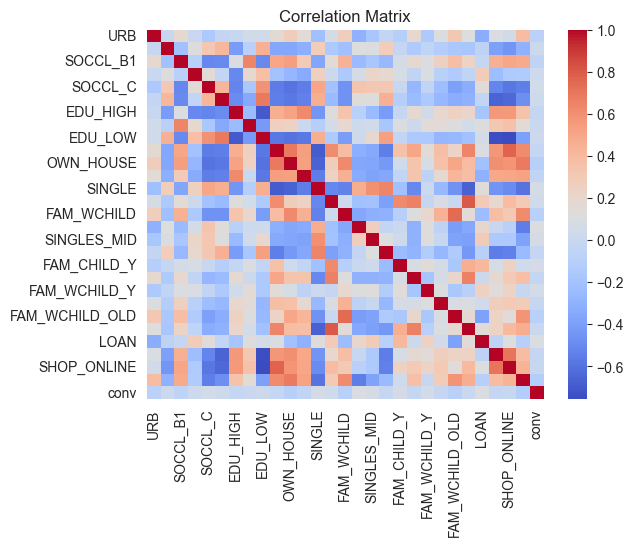

In [37]:
numeric_cols = df_tb.select_dtypes(include='number').columns
corr = df_tb[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# CLUSTERING

In [38]:
df_sub = df_tb[df_tb["conv"]==1].copy()

In [39]:
df_sub = df_sub.drop(columns = ["conv"])

In [40]:
df_sub_clean = df_sub.dropna()  # or use imputation if many missing

In [41]:
categorical_cols = df_sub.select_dtypes(include='object').columns
df_sub_encoded = pd.get_dummies(df_sub_clean, columns=categorical_cols, drop_first=True)

In [42]:
X = df_sub_encoded.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

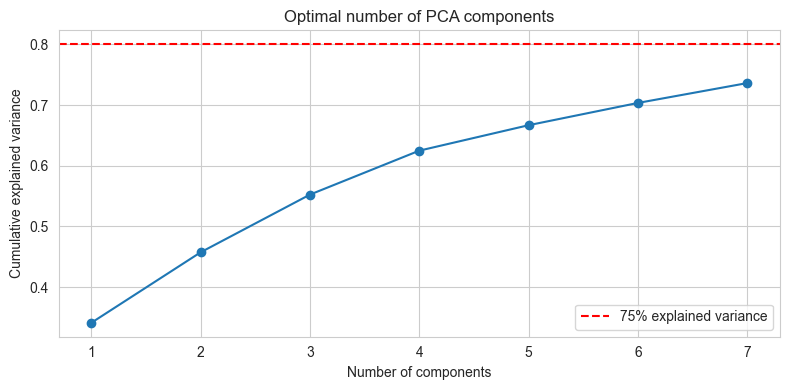

Optimal number of PCA components: 1


In [100]:
pca = PCA(n_components = 7)
X_pca = pca.fit_transform(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.80, color='r', linestyle='--', label='75% explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Optimal number of PCA components')
plt.legend()
plt.tight_layout()
plt.show()

# Select number of components where cum_var > desired threshold (e.g., 0.9)
n_components = np.argmax(cum_var >= 0.9) + 1
print(f"Optimal number of PCA components: {n_components}")

In [101]:
components = pca.components_
clustering_feature_cols = df_sub.columns.tolist()
n_top = 5
top_features = {}

for i, comp in enumerate(components[0:10]):
    indices = np.argsort(np.abs(comp))[::-1][:n_top]
    top_features[f'PC{i+1}'] = [(clustering_feature_cols[idx], comp[idx]) for idx in indices]

# Optionally convert to DataFrame for easy viewing
rows = []
for pc, feats in top_features.items():
    for feat, weight in feats:
        rows.append({'PC': pc, 'Feature': feat, 'Loading': weight})
        

In [102]:
df_pca_loadings = pd.DataFrame(rows)

In [103]:
print(df_pca_loadings)

     PC         Feature   Loading
0   PC1          SINGLE  0.281162
1   PC1       OWN_HOUSE -0.276238
2   PC1            DINK -0.270089
3   PC1     SHOP_ONLINE -0.243156
4   PC1         EDU_LOW  0.242690
5   PC2     FAM_CHILD_Y  0.459981
6   PC2            LOAN  0.414522
7   PC2             FAM  0.394598
8   PC2  FAM_WCHILD_OLD -0.314471
9   PC2   CIT_HOUSEHOLD  0.254196
10  PC3     FAM_CHILD_O  0.318534
11  PC3   CIT_HOUSEHOLD  0.302351
12  PC3         EDU_LOW  0.299043
13  PC3             FAM  0.276791
14  PC3   SINGLES_YOUNG -0.274689
15  PC4         EDU_MID  0.454302
16  PC4        EDU_HIGH -0.439529
17  PC4        SOCCL_B2  0.395583
18  PC4        SOCCL_B1  0.372790
19  PC4      FAM_WCHILD  0.205456
20  PC5  FAM_WCHILD_MED  0.608060
21  PC5      FAM_WCHILD  0.366094
22  PC5    FAM_WCHILD_Y  0.292934
23  PC5         EDU_MID -0.266686
24  PC5     FAM_CHILD_O -0.230687
25  PC6    INCOME_final  0.496612
26  PC6        SOCCL_B2 -0.415653
27  PC6         EDU_MID  0.319467
28  PC6       

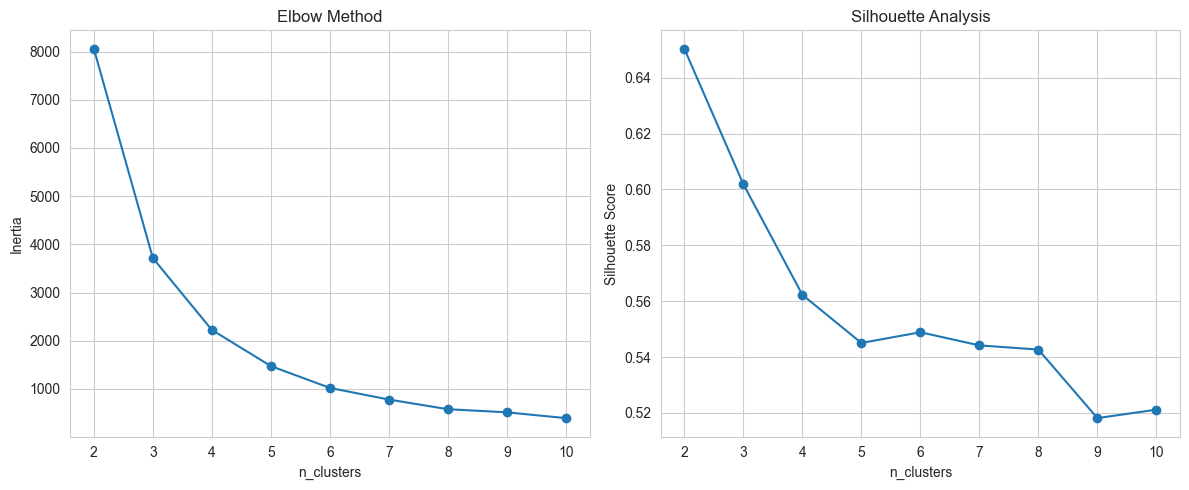

Optimal number of clusters by silhouette: 2


In [104]:
sil_scores = []
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(X_pca[:, :n_components])  # use reduced data
    sil = silhouette_score(X_pca[:, :n_components], labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Optionally, print best k by silhouette
best_k = K[np.argmax(sil_scores)]
print(f"Optimal number of clusters by silhouette: {best_k}")


In [105]:
sil_matrix = np.zeros((10, 10))  # 10 components x 10 clusters example

for nc in range(2, 11):
    pca_cycle = PCA(n_components=nc)
    X_pc = pca_cycle.fit_transform(X_scaled)
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=1)
        labels = kmeans.fit_predict(X_pc)
        sil = silhouette_score(X_pc, labels)
        sil_matrix[nc-1, k-1] = sil

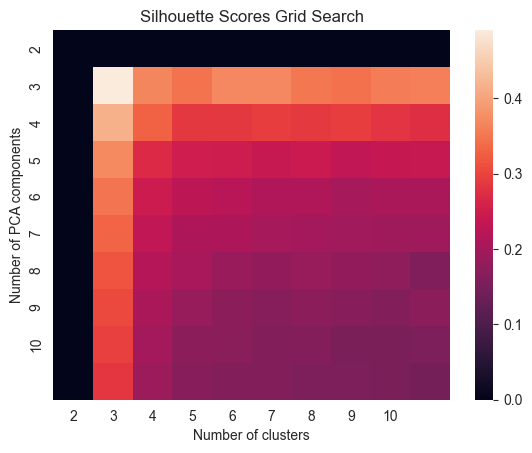

In [106]:
sns.heatmap(sil_matrix, xticklabels=range(2,11), yticklabels=range(2,11))
plt.xlabel('Number of clusters')
plt.ylabel('Number of PCA components')
plt.title('Silhouette Scores Grid Search')
plt.show()

In [129]:
kmeans_pca = KMeans(n_clusters=6, random_state=1)
labels_pca = kmeans_pca.fit_predict(X_pca)
score_pca = silhouette_score(X_pca, labels_pca)
print(f'Silhouette score with PCA: {score_pca:.3f}')

Silhouette score with PCA: 0.179


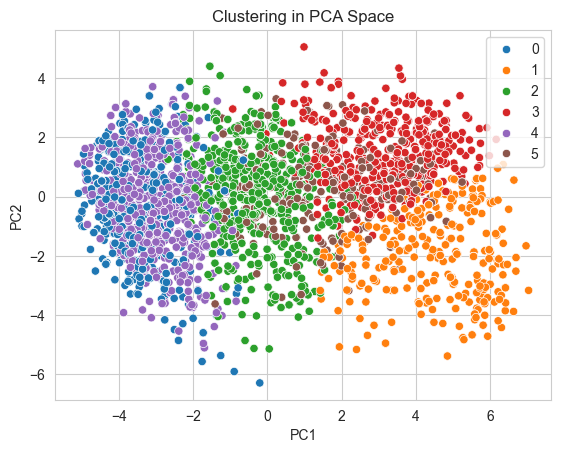

In [130]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

In [131]:
# Adjust the range if you used a different number of components
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['cluster'] = labels_pca.astype(str)  # Convert to string for color-coding

In [132]:
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -4.457326 -0.401405  1.012805  0.369833  0.487662  1.434517 -0.194829   
1     0.095692 -1.124379 -0.802150  2.280761 -0.071280  1.445220 -0.096476   
2    -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   
3    -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   
4    -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   
...        ...       ...       ...       ...       ...       ...       ...   
3649 -1.512157 -0.147046 -1.693600  1.829619  0.122169  0.224016 -0.227346   
3650 -5.089455  0.108584  1.592114 -3.472303  0.776960 -0.620869  0.843427   
3651  0.947700  0.820584  0.278315  1.461276  0.194438  0.459815  0.402151   
3652 -2.834491 -3.616396 -0.109287  0.136108  0.304236  0.743202  0.242998   
3653 -2.962461 -1.220023  0.919152  0.993198 -2.091164 -0.073756  0.648833   

     cluster  
0          4  
1          2  
2          4  
3          4  
4          4  
...      ...  
3649       2  
3650       0  
3651       2  
3652       4  
3653       4  

[3654 rows x 8 columns]

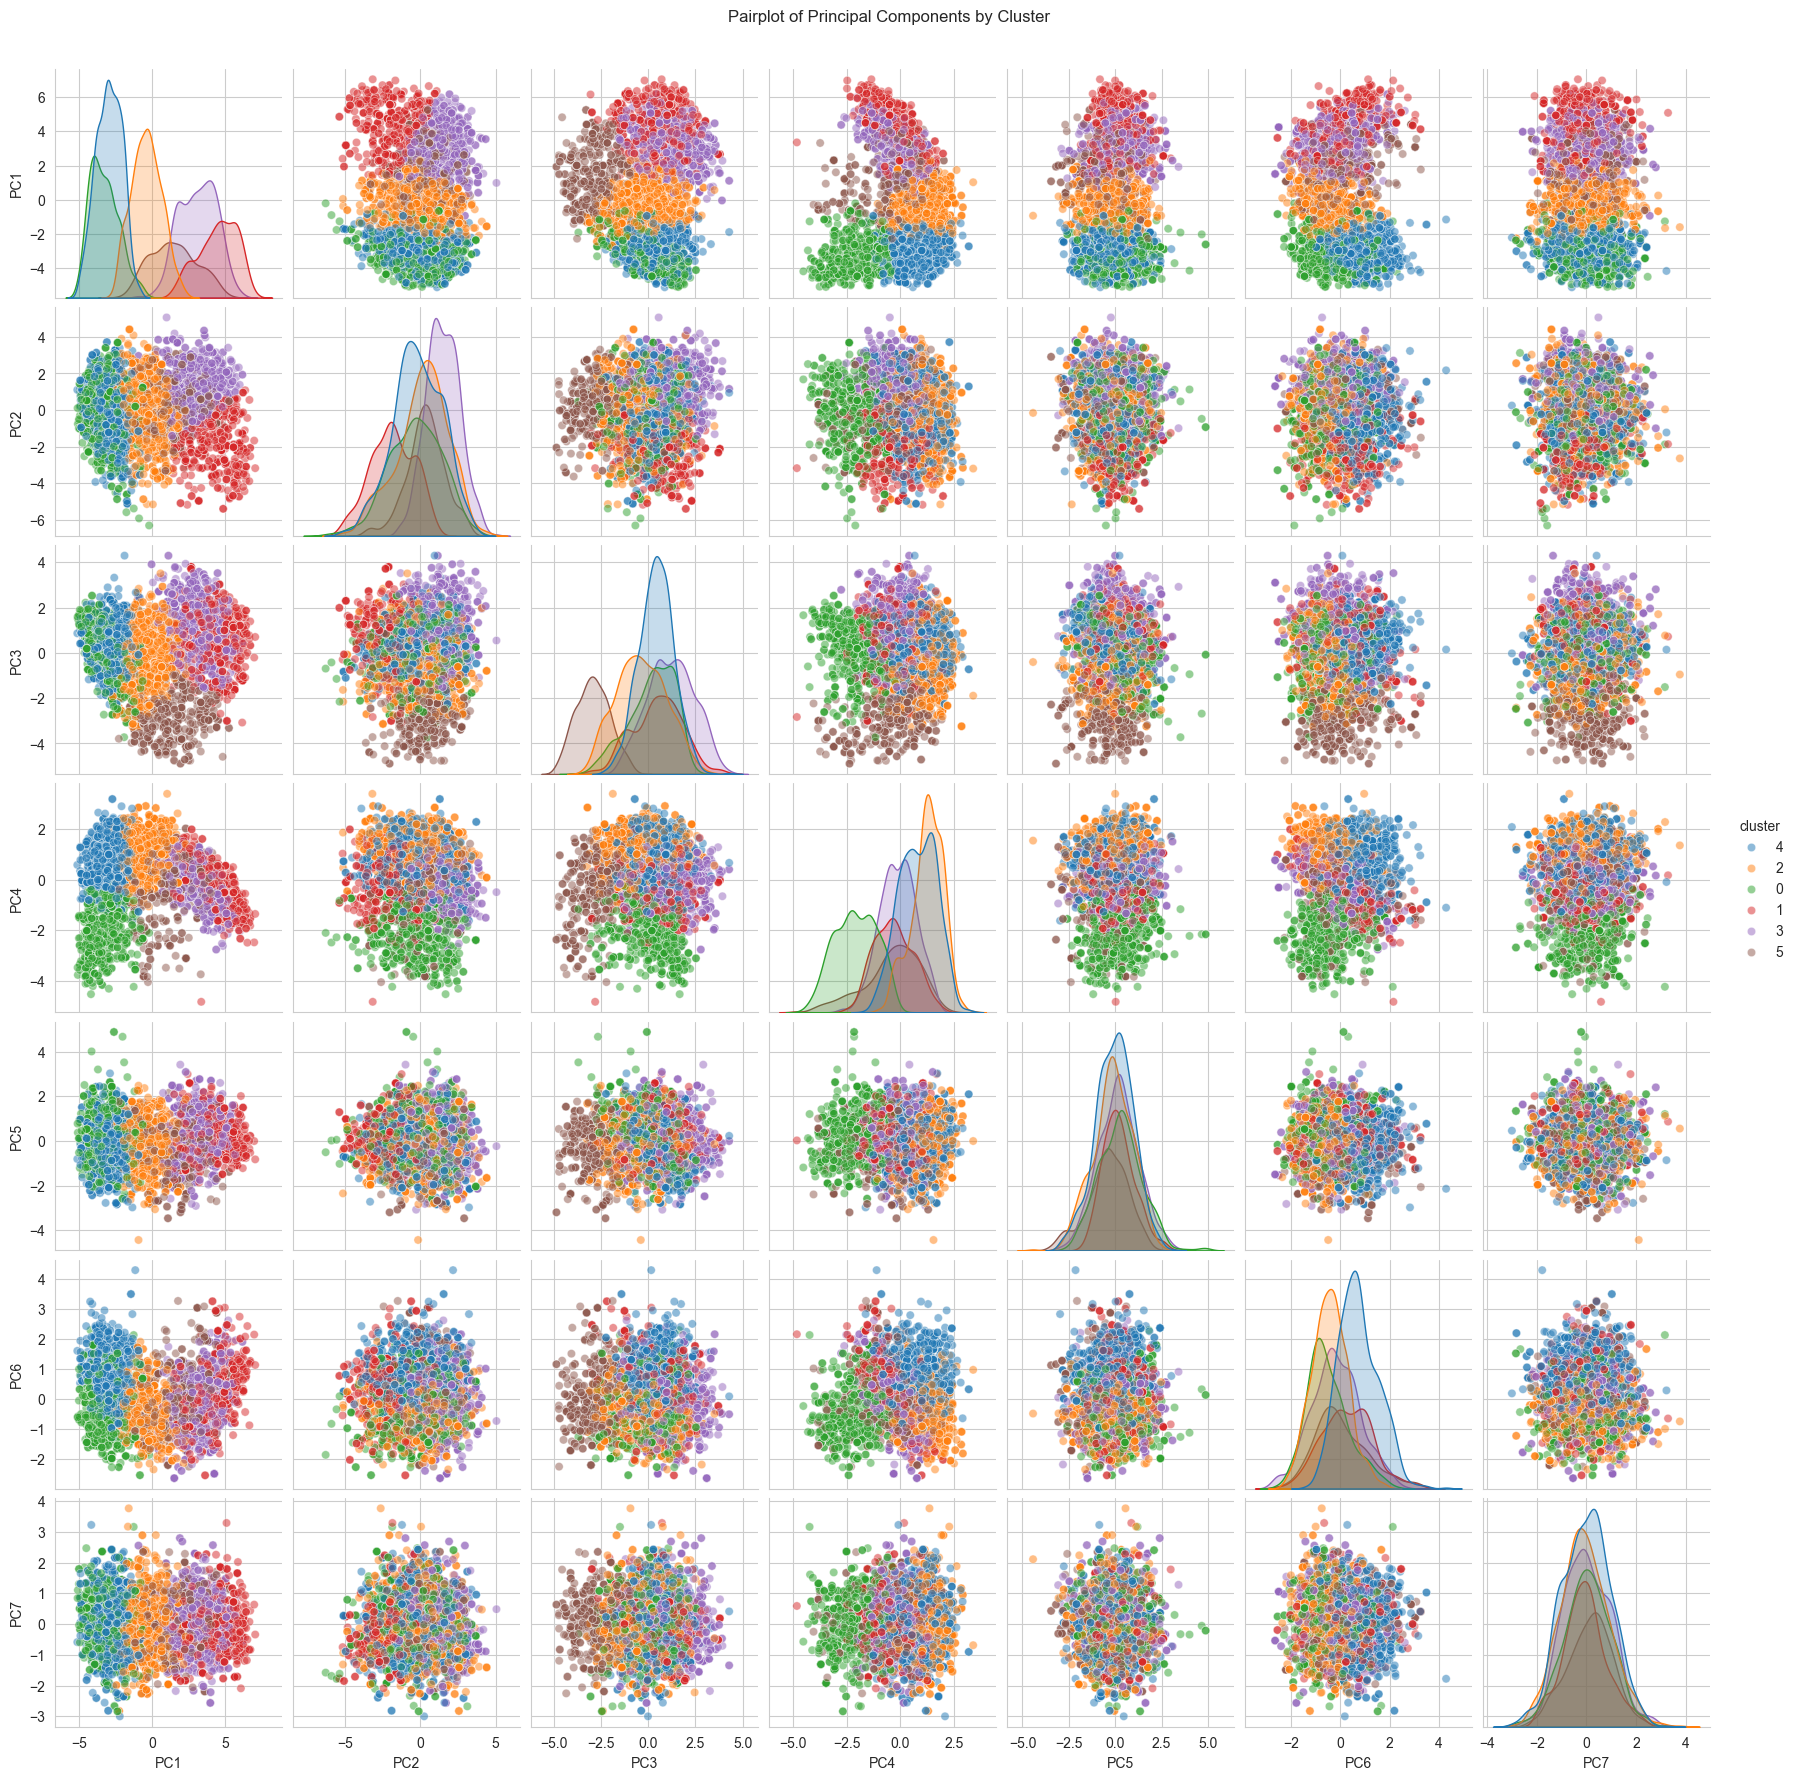

In [133]:
sns.pairplot(
    df_pca, 
    vars=pc_columns,         # All PC columns
    hue='cluster',           # Color by cluster
    palette='tab10',         # Nice color scheme
    plot_kws={'alpha': 0.5}  # Transparency for overlap
)
plt.suptitle('Pairplot of Principal Components by Cluster', y=1.02)
plt.show()

In [134]:
df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -4.457326 -0.401405  1.012805  0.369833  0.487662  1.434517 -0.194829   
1  0.095692 -1.124379 -0.802150  2.280761 -0.071280  1.445220 -0.096476   
2 -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   
3 -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   
4 -2.791497  0.547862  1.091394 -1.155767 -1.154897  0.663290  0.234572   

  cluster  
0       4  
1       2  
2       4  
3       4  
4       4

In [135]:
df_sub.head()

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
1109  2.0           2.0       3.0       1.0      1.0      1.0       4.0   
1120  4.0           2.0       4.0       1.0      1.0      1.0       2.0   
1220  2.0           2.0       4.0       2.0      1.0      1.0       2.0   
1237  2.0           4.0       1.0       3.0      3.0      2.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_CHILD_Y  FAM_CHILD_O  FAM_WCHILD_Y  \
952       3.0      2.0   5.0  ...          4.0          3.0           1.0   
1109      3.0      2.0   6.0  ...          3.0          4.0           1.0   
1120      5.0      1.0   4.0  ...          3.0          1.0           1.0   
1220      5.0      2.0   6.0  ...          3.0          4.0           3.0   
1237      2.0      4.0   2.0  ...          3.0          4.0           4.0   

      FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  \
952              1.0             3.0            5.0   1.0      4.0   
1109             2.0             4.0            5.0   2.0      6.0   
1120             3.0             4.0            3.0   1.0      5.0   
1220             2.0             3.0            5.0   4.0      5.0   
1237             1.0             1.0            4.0   3.0      2.0   

      SHOP_ONLINE  CAR  
952           6.0  5.0  
1109          6.0  5.0  
1120          4.0  5.0  
1220          6.0  5.0  
1237          2.0  2.0  

[5 rows x 28 columns]

In [136]:
labels_pca.shape

(3654,)

In [137]:
df_tb.head()

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787  5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873  4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952  7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953  7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954  7.0           2.0       3.0       2.0      2.0      1.0       4.0   

     EDU_MID  EDU_LOW  DINK  ...  FAM_WCHILD_Y  FAM_WCHILD_MED  \
787      4.0      2.0   6.0  ...           1.0             3.0   
873      5.0      2.0   3.0  ...           1.0             2.0   
952      3.0      2.0   5.0  ...           1.0             1.0   
953      3.0      2.0   5.0  ...           1.0             1.0   
954      3.0      2.0   5.0  ...           1.0             1.0   

     FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE  CAR  conv  \
787             4.0            5.0   1.0      5.0          6.0  5.0     0   
873             4.0            4.0   2.0      5.0          3.0  3.0     0   
952             3.0            5.0   1.0      4.0          6.0  5.0     1   
953             3.0            5.0   1.0      4.0          6.0  5.0     0   
954             3.0            5.0   1.0      4.0          6.0  5.0     0   

     cluster  
787        0  
873        2  
952        0  
953        0  
954        0  

[5 rows x 30 columns]

# MODELLING

In [138]:
joblib.dump(scaler,  'scaler.pkl')
joblib.dump(pca,     'pca.pkl')
joblib.dump(kmeans_pca,  'kmeans_pca.pkl')

['kmeans_pca.pkl']

In [139]:
feat_cols = df_sub.columns

In [140]:
X_tb = df_tb.copy()          # raises if a col is missing → healthier

X_tb = X_tb.reindex(columns=feat_cols)

In [141]:
X_tb

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787   5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873   4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
...   ...           ...       ...       ...      ...      ...       ...   
9364  6.0           3.0       4.0       2.0      2.0      2.0       2.0   
9366  4.0           1.0       1.0       1.0      1.0      1.0       5.0   
9367  2.0           4.0       3.0       3.0      2.0      3.0       1.0   
9371  4.0           2.0       4.0       1.0      2.0      1.0       3.0   
9372  7.0           2.0       4.0       2.0      1.0      1.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_CHILD_Y  FAM_CHILD_O  FAM_WCHILD_Y  \
787       4.0      2.0   6.0  ...          4.0          3.0           1.0   
873       5.0      2.0   3.0  ...          3.0          2.0           1.0   
952       3.0      2.0   5.0  ...          4.0          3.0           1.0   
953       3.0      2.0   5.0  ...          4.0          3.0           1.0   
954       3.0      2.0   5.0  ...          4.0          3.0           1.0   
...       ...      ...   ...  ...          ...          ...           ...   
9364      5.0      2.0   5.0  ...          3.0          2.0           3.0   
9366      1.0      1.0   6.0  ...          3.0          4.0           1.0   
9367      4.0      3.0   4.0  ...          3.0          3.0           1.0   
9371      4.0      1.0   2.0  ...          1.0          3.0           1.0   
9372      4.0      2.0   4.0  ...          2.0          4.0           1.0   

      FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  \
787              3.0             4.0            5.0   1.0      5.0   
873              2.0             4.0            4.0   2.0      5.0   
952              1.0             3.0            5.0   1.0      4.0   
953              1.0             3.0            5.0   1.0      4.0   
954              1.0             3.0            5.0   1.0      4.0   
...              ...             ...            ...   ...      ...   
9364             2.0             3.0            3.0   4.0      6.0   
9366             3.0             3.0            6.0   2.0      6.0   
9367             3.0             2.0            4.0   4.0      4.0   
9371             3.0             4.0            3.0   2.0      3.0   
9372             1.0             4.0            5.0   3.0      5.0   

      SHOP_ONLINE  CAR  
787           6.0  5.0  
873           3.0  3.0  
952           6.0  5.0  
953           6.0  5.0  
954           6.0  5.0  
...           ...  ...  
9364          6.0  5.0  
9366          6.0  5.0  
9367          4.0  5.0  
9371          3.0  5.0  
9372          5.0  5.0  

[3654 rows x 28 columns]

In [142]:
# load objects -----------------------------------------------------------
scaler  = joblib.load('scaler.pkl')
pca     = joblib.load('pca.pkl')
kmeans_pca_model  = joblib.load('kmeans_pca.pkl')

# 1. feature matrix ------------------------------------------------------
X_tb = df_tb[feat_cols].copy()

# 2. identical preprocessing --------------------------------------------
X_scaled = scaler.transform(X_tb)          # **do NOT refit** the scaler!

# 3. project to PC space -------------------------------------------------
X_pc     = pca.transform(X_scaled)         # shape: (3654, 8)

In [143]:
X_scaled

array([[ 0.87337054, -0.92793654,  1.61484694, ...,  0.52586502,
         1.03079896,  1.02719393],
       [ 0.35719159,  2.2377734 ,  0.6928886 , ...,  0.52586502,
        -0.62961701, -0.26542479],
       [ 1.90572845, -0.92793654,  0.6928886 , ..., -0.13932008,
         1.03079896,  1.02719393],
       ...,
       [-0.67516631,  0.65491843,  0.6928886 , ..., -0.13932008,
        -0.07614502,  1.02719393],
       [ 0.35719159, -0.92793654,  1.61484694, ..., -0.80450519,
        -0.62961701,  1.02719393],
       [ 1.90572845, -0.92793654,  1.61484694, ...,  0.52586502,
         0.47732697,  1.02719393]], shape=(3654, 28))

In [144]:
# 4. assign clusters -----------------------------------------------------
df_tb['cluster'] = kmeans_pca_model.predict(X_pc)

In [145]:
df_tb['cluster'].value_counts()

cluster
4    846
2    730
3    676
0    567
1    444
5    391
Name: count, dtype: int64

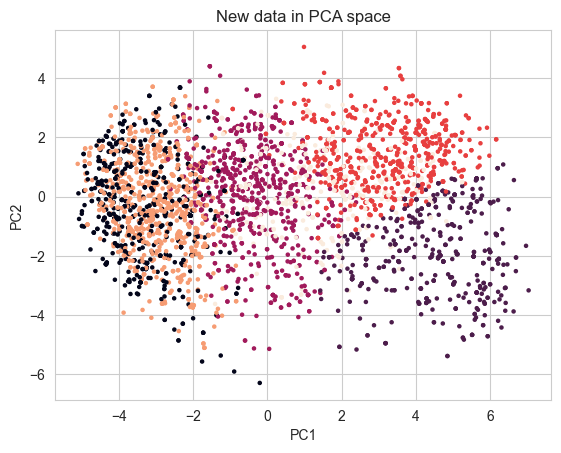

In [146]:
plt.scatter(X_pc[:,0], X_pc[:,1], c=df_tb['cluster'], s=5)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('New data in PCA space')
plt.show()

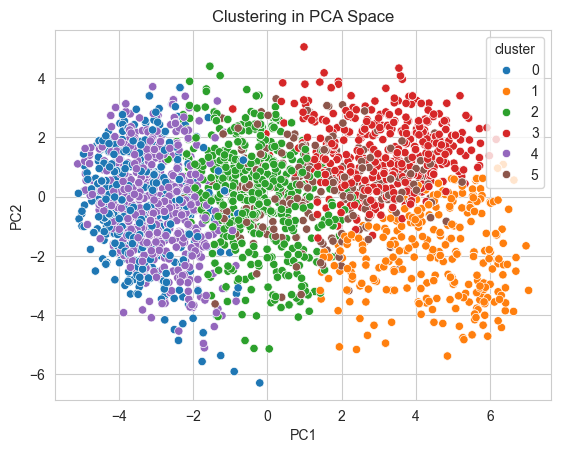

In [147]:
sns.scatterplot(x=X_pc[:,0], y=X_pc[:,1], hue=df_tb['cluster'], palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

In [148]:
import numpy as np

# 1. How many centroids did the stored model have?
print("k =", kmeans_pca.n_clusters)                # e.g. 8

# 2. Which labels occurred in the TRAINING run?
train_labels = np.unique(kmeans_pca.labels_)
print("labels seen during fit:", train_labels) # e.g. [0 1 2 4 5 6 7] -> centroid 3 was empty

# 3. Which labels turn up in the NEW data?
new_labels = np.unique(kmeans_pca_model.predict(X_pc))
print("labels seen in df_tb:", new_labels)     # e.g. [0 1 2 3 4 5 6 7]


k = 6
labels seen during fit: [0 1 2 3 4 5]
labels seen in df_tb: [0 1 2 3 4 5]


In [149]:
# make sure df_tb already has the 'cluster' column you created earlier
# -------------------------------------------------------------------

pivot_conv_clusters = (df_tb
                       .groupby('conv')['cluster']          # group by the conversion flag
                       .unique()                           # keep only distinct cluster labels
                       .apply(lambda arr: sorted(arr))     # (optional) sort the list of labels
                       .reset_index(name='clusters'))      # tidy DataFrame shape

pivot_conv_clusters


conv            clusters
0     0  [0, 1, 2, 3, 4, 5]
1     1  [0, 1, 2, 3, 4, 5]

In [151]:
# ── 1. conversion rate + row count per cluster ───────────────────────
conv_rate_by_cluster = (
    df_tb
      .groupby('cluster')                       # one row per cluster
      .agg(
          conv_rate=('conv', 'mean'),           # average conversion rate
          n_rows   =('conv', 'size')            # number of rows / customers
      )
      .reset_index()                            # tidy two-column index
)

conv_rate_by_cluster


cluster  conv_rate  n_rows
0        0   0.125220     567
1        1   0.094595     444
2        2   0.094521     730
3        3   0.204142     676
4        4   0.104019     846
5        5   0.202046     391